# A Deep Dive into Fake news

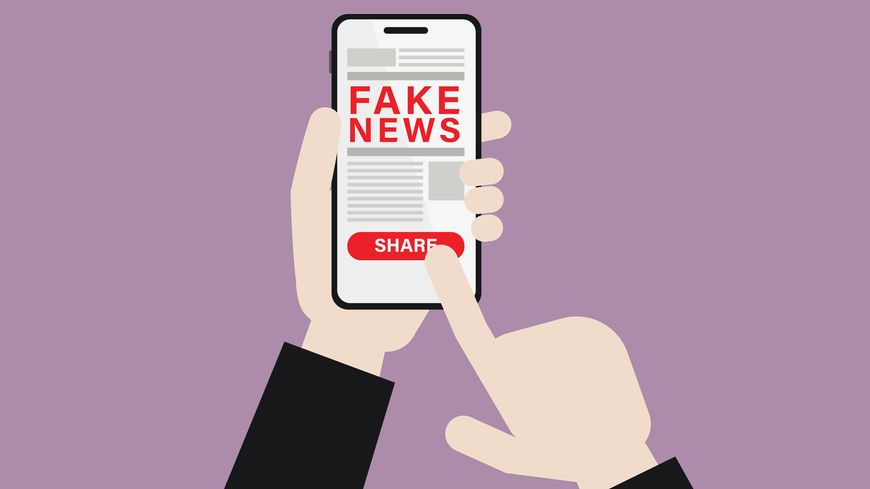

Introduction and research question goes here!!!

## Imports

In [48]:
RANDOM_SEED = 1234

# Basic imports
from pathlib import Path
import re
import pandas as pd
import numpy as np; np.random.seed(RANDOM_SEED)
import random
from datetime import datetime

# Off the shell libraries
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import eli5
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Supervised text classification
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.linear_model import (
    LogisticRegression)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import (
    make_pipeline, Pipeline)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn import metrics
import joblib 

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Basic path
data_path = Path().resolve().parent / 'data'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\juans\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juans\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juans\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


## Data Adquisition & preprocessing

Initially, scraping techniques were considered to build our own dataset containing different sources of news articles to compare to their fake equivalents. However, this process became quite time consuming and complex as each web page has its own layout. Hence, a custom scraping script using BeautifulSoup and Selenium should be created. However, [Insert reference of WELFake_dataset] constructed a dataset with more than 72,000 articles from different sources (BBC,). We then proceed to star some cleaning of the text files

In [36]:
df = pd.read_csv(data_path/'WELFake_Dataset.csv', index_col=[0]).replace('', np.nan)
# Standardizing text to lower case
df.title = df.title.str.strip().str.lower()
df.text = df.text.str.strip().str.lower()
print(f'There are {len(df)} articles.')
df.head()

There are 72134 articles.


,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,NaN,did they post their votes for hillary already?,1
2,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last n...",1
3,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0
4,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1


As the dataset is quite big for the purpose of study, splitting it to work only with news articles that come from Reuters is a nice idea. Also, it is important to check for NAs and a good length of the article to have some meaning.

<AxesSubplot:>

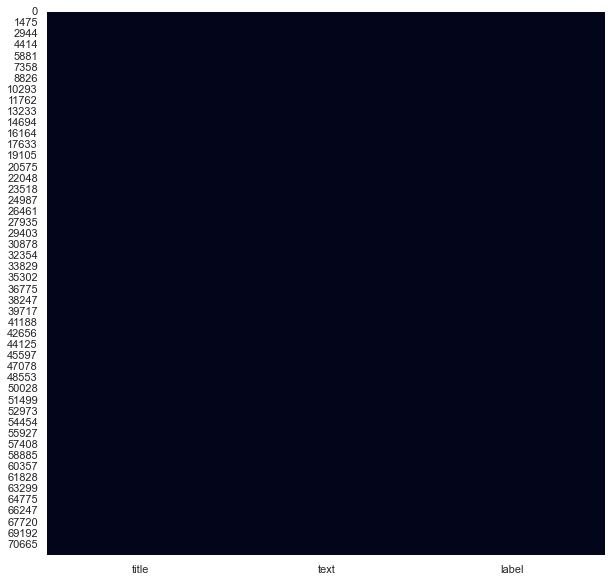

In [91]:
#Checking Nulls
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(),cbar=False)

As the dataset contains a low value of null values (less than 600 over 72.000), we proceed to eliminate such observations for futher analysis.

There are 71537 articles after NA analysis.


<AxesSubplot:>

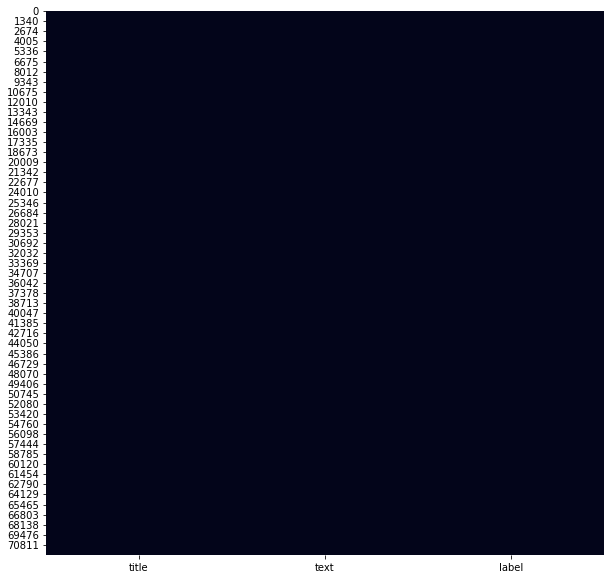

In [38]:
#Remove NaN in column text
df = df.dropna()
print(f'There are {len(df)} articles after NA analysis.')
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(),cbar=False)

In [57]:
df_reuters = df[df.text.str.contains("reuters")].reset_index(drop= True)
print(f'There are {len(df_reuters)} articles.')
df_reuters.head()

There are 22297 articles.


,title,text,label
0,"may brexit offer would hurt, cost eu citizens ...",brussels (reuters) - british prime minister th...,0
1,schumer calls on trump to appoint official to ...,"washington (reuters) - charles schumer, the to...",0
2,billionaire odebrecht in brazil scandal releas...,rio de janeiro/sao paulo (reuters) - billionai...,0
3,u.n. seeks humanitarian pause in sanaa where s...,geneva (reuters) - the united nations called o...,0
4,second judge says clinton email setup may have...,new york (reuters) - a second federal judge ha...,0


Up next, we extract the location of such articles just to add extra info to our analysis. This is also helpful to remove cities for topic analysis from the text, as they would become frequent words in the corpus.

## Descriptive analysis

We then proceed to analyze what are the most common words on the dataset (for fake and real dataset) and also the most frequent n-gram combinations for the articles.

## Sentiment Analysis - Of the shell library

As we are dealing with a large dataset, it was important to check overall sentiment of the articles in a fast way. That way, it should be interesting to check wether sentimente varies between fake news and real ones. Vader was the off the shell library to use as 

In [85]:
def get_sentiment_score(dataframe, column = 'text'):
    time = datetime.now().strftime("%H:%M:%S")
    sent_analyzer = SentimentIntensityAnalyzer()
    text_corpus = dataframe[column].to_list()
    predictions_df = []
    print(f'Initializign predictions for {column} - {time}')
    for idx,article in enumerate(text_corpus):
        time = datetime.now().strftime("%H:%M:%S")
        print(f"\rModel working in article {idx} at {time}", end="") 
        score = sent_analyzer.polarity_scores(article)
        result = {
            f'score_{column}': score['compound'],
            f'likelihood_{column}': 'pos' if score['compound'] > 0 else 'neg'
        }

        predictions_df.append(result)
    print(f'\nPrediction complete at {time}.')
    return pd.DataFrame(predictions_df)

In [87]:
df_sent = df.join(get_sentiment_score(df, 'title')).join(get_sentiment_score(df, 'text'))
df_sent.head()

Initializign predictions for title - 19:38:34
Model working in article 71536 at 19:38:44
Prediction complete at 19:38:44.
Initializign predictions for text - 19:38:44
Model working in article 71536 at 19:45:32
Prediction complete at 19:45:32.


,title,text,label,score_title,likelihood_title,score_text,likelihood_text
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,-0.6908,neg,-0.9928,neg
2,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last n...",1,0.4767,pos,0.9993,pos
3,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0,-0.5719,neg,-0.9081,neg
4,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,-0.5093,neg,-0.9255,neg
5,about time! christian group sues amazon and sp...,all we can say on this one is it s about time ...,1,0.0000,neg,0.0000,neg


In [88]:
df_sent.to_csv(data_path/'WELFake_Dataset_sentiment.csv')

Text(0.5, 1.0, 'Sentiment score per fake and real articles')

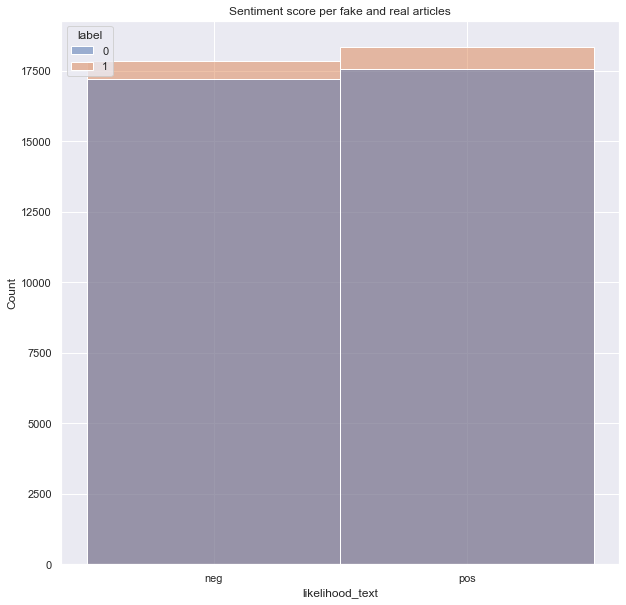

In [90]:
# Plotting
plt.figure(figsize=(10, 10))
ax = sns.histplot(data = df_sent, 
x='likelihood_text', hue='label')
ax.set_title('Sentiment score per fake and real articles')

## Topic Classification - LDA

## Building a model - Is the article fake or not?

### Naive Bayes Algorithm with Count Vector Features

80% train,test, split

In [92]:
y = df.label
X = df.text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

In [93]:
vectorizer = CountVectorizer(stop_words="english")
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

rep=metrics.classification_report(y_test, y_pred)
print(rep)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7081
           1       0.91      0.87      0.89      7227

    accuracy                           0.89     14308
   macro avg       0.89      0.89      0.89     14308
weighted avg       0.89      0.89      0.89     14308



Although Naive Bayes is a very simple algorithm we have good classification accuracies.

### Logistic Regression with TF-IDF Features

We make test(60%) - validation (20%) - test (20%) split

In [94]:
y = df.label
X = df.text
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1) #test set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # validation set

Using 2 word ngrams to capture the information from group of words.

In [95]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)
X_train_text = text_transformer.fit_transform(X_train)
X_val_text = text_transformer.transform(X_val)
X_test_text = text_transformer.transform(X_test)

In [ ]:
X_train_text.shape, X_val_text.shape

In [ ]:
logit = LogisticRegression(multi_class='multinomial', random_state=42, n_jobs=4)

We perform 5-fold cross-validation to find the best fit.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
cv_results = cross_val_score(logit, X_train_text, y_train, cv=skf, scoring='f1_micro')

In [ ]:
cv_results, cv_results.mean()

In [ ]:
%%time
logit.fit(X_train_text, y_train)

Logistic regression using tf-idf features achieved around 95 percent accuracy. We pick it as our final model.

## References

*seaborn.kdeplot - seaborn 0.11.2 documentation* (n.d.). Seaborn: Statistical Data Visualization. Retrieved June 18, 2022, from https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot 

*sklearn.linear_model.LogisticRegression — scikit-learn 0.24.2 documentation. (n.d.).* Scikit-Learn: Machine Learning in Python. Retrieved June 18, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

*sklearn.naive_bayes.MultinomialNB — scikit-learn 0.24.2 documentation. (n.d.).* Scikit-Learn: Machine Learning in Python. Retrieved June 18, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html